### Example notebook demonstrating the use of projected quantum kernels (PQKs) for subsequent use in QSVC

This notebook demonstrates how to calculate a projected quantum kernel. It applies the kernel to classify a two-moon data set using an SVM algorithm. The kernel is defined using a quantum neural network (QNN) and a Chebyshev polynomial parameterized quantum circuit (PQC), which induces the corresponding encoding circuit. The QNN includes Pauli Z, X, and Y expectation values as cost operators, which are used to estimate the kernel matrix elements. The kernel is evaluated for a given set of parameters and used to train an SVM classifier. Finally, the accuracy score and decision function of the classifier are plotted.

In [1]:
import numpy as np
from qiskit_aer import Aer
from qiskit.primitives import Estimator
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.metrics import accuracy_score

from squlearn.kernel import ProjectedQuantumKernel
from squlearn.kernel import QSVC
from squlearn.encoding_circuit import ChebyshevPQC
from squlearn.util import Executor

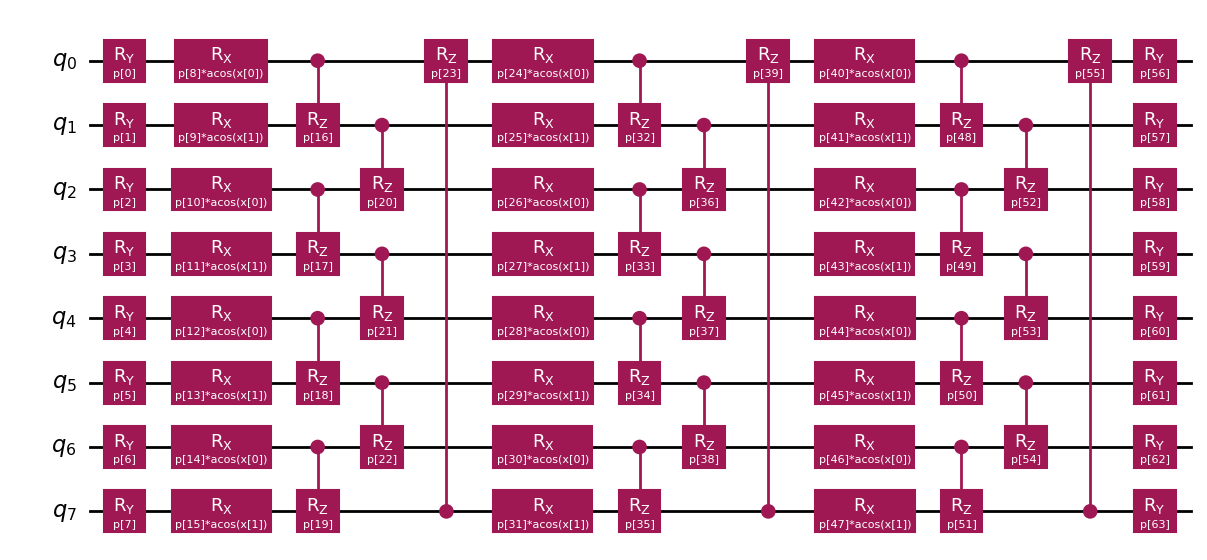

In [2]:
# Define the encoding of the data
nqubits = 8
number_of_layers = 3
fm = ChebyshevPQC(nqubits, 2, num_layers=number_of_layers)
fm.draw("mpl")

In [3]:
# Create the Projected Quantum Kernel with measurements in the X,Y,Z, basis
# Hyperparameter gamma of the outer RBF kernel is set to 0.5
pqk_instance = ProjectedQuantumKernel(
    encoding_circuit=fm, executor=Executor("qulacs"), measurement="XYZ", gamma=0.5
)

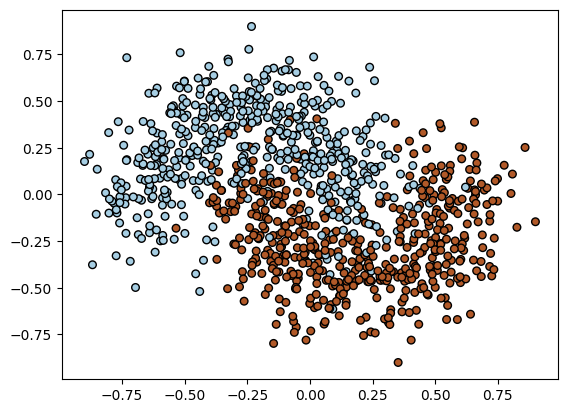

In [4]:
# Load the moon dataset and visualize the points and two classes
X, Y = make_moons(n_samples=1000, noise=0.3, random_state=0)
Scaler = MinMaxScaler((-0.9, 0.9))
Scaler.fit(X)
X = Scaler.transform(X)
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired, edgecolors="k")

In [5]:
# load an array of optimal trainable parameters which have been previously optimized
# outside of this notebook
param = np.array(
    [
        4.10944721e-01,
        9.06258059e-02,
        8.07136569e-02,
        1.58474218e-01,
        2.02571844e00,
        2.00015689e00,
        1.12177849e00,
        1.32730454e00,
        2.07903620e-01,
        5.56881033e-01,
        3.29443096e-01,
        -2.32345080e-02,
        1.71856057e00,
        1.75351224e00,
        1.90727995e00,
        1.94577930e00,
        2.14202107e-01,
        -1.23412157e-03,
        5.98468274e-01,
        6.07501598e-02,
        8.32329831e-01,
        1.82418966e00,
        4.08609353e-01,
        1.46545246e00,
        4.71027495e-01,
        1.47506018e00,
        7.98754330e-01,
        2.98134296e-01,
        8.43787094e-01,
        4.89291253e-01,
        5.40119600e-01,
        8.26128075e-01,
    ]
)

np.random.seed(0)
param = np.random.rand(fm.num_parameters)

# Assign optimal parameters to PQK instance
pqk_instance.assign_parameters(param)

In [6]:
# Create a Quantum Support Vector Classifier (QSVC) instance and fit the data
qsvc_instance = QSVC(quantum_kernel=pqk_instance)
qsvc_instance.fit(X, Y)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
     decision_function_shape='ovr', max_iter=-1, probability=False,
     quantum_kernel=<squlearn.kernel.matrix.projected_quantum_kernel.ProjectedQuantumKernel object at 0x0000019B1889E1F0>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [7]:
# Predict the labels of the training data and calculate the accuracy score of the trained data
qsvc_predictions = qsvc_instance.predict(X)
print(f"accuracy score {accuracy_score(Y, qsvc_predictions)}")

accuracy score 0.911


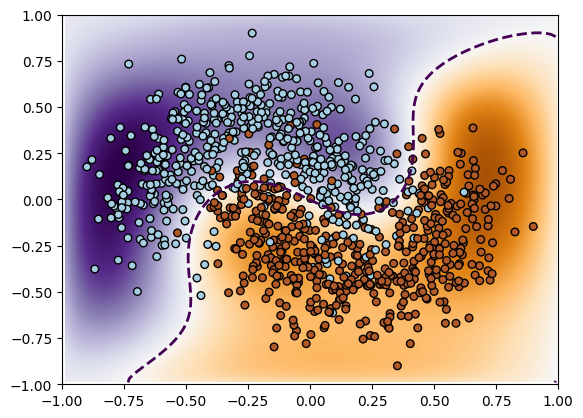

In [8]:
# Plot the decision function of thr QSVC for each data point on a grid
xx, yy = np.meshgrid(np.linspace(-0.99, 0.99, 100), np.linspace(-0.99, 0.99, 100))
Z = qsvc_instance.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
norm = mpl.colors.Normalize(
    vmin=-max(abs(np.min(Z)), abs(np.max(Z))), vmax=max(abs(np.min(Z)), abs(np.max(Z)))
)
im = plt.imshow(
    Z,
    interpolation="bilinear",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
    norm=norm,
)
# Plot the decision boundary where the decision function is equal to 0
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")

# Plot training data points
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired, edgecolors="k")
plt.axis([-1, 1, -1, 1])
plt.show()